In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

### Reading the Input Data

In [2]:
data=pd.read_csv('Twitter_Data.csv')
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### Data Exploration and Pre-processing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
clean_text    162976 non-null object
category      162973 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
data['clean_text']=data['clean_text'].astype('str')

In [5]:
# Removing NULL records from the data
data=data.dropna(axis=0,how="any")
data=data.reset_index(drop=True)
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
#Adding a new Column with sentiment Values {Positive, Neutral, Negative} against category {1,0,-1}
sentiment_map={-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'}
data['sentiment']=data['category'].map(sentiment_map)
data.head()

,clean_text,category,sentiment
0,when modi promised “minimum government maximum...,-1.0,Negative
1,talk all the nonsense and continue all the dra...,0.0,Neutral
2,what did just say vote for modi welcome bjp t...,1.0,Positive
3,asking his supporters prefix chowkidar their n...,1.0,Positive
4,answer who among these the most powerful world...,1.0,Positive


In [7]:
temp=data.groupby('sentiment').count()['clean_text'].reset_index().sort_values(by='clean_text', ascending=False)
temp.style.background_gradient(cmap='Greens')

,sentiment,clean_text
2,Positive,72250
1,Neutral,55213
0,Negative,35510


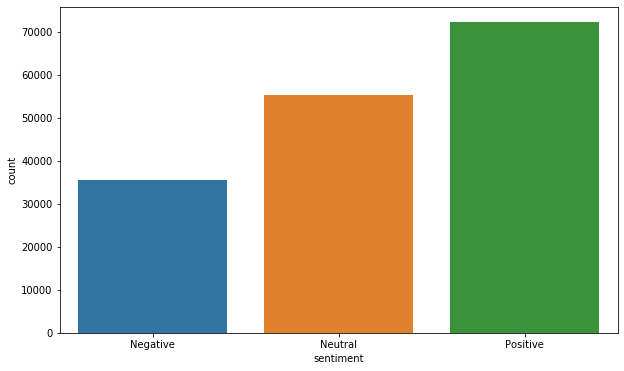

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', data=data)

#### Observation : We can notice that most of the text have positive sentiment. Each sentiment category has significant data entries and the data is slightly imbalanced.

In [9]:
# remove the special characters, numbers and punctuations
data['clean_text']= data['clean_text'].str.replace("[^a-zA-Z]", " ")
data.head()

,clean_text,category,sentiment
0,when modi promised minimum government maximum...,-1.0,Negative
1,talk all the nonsense and continue all the dra...,0.0,Neutral
2,what did just say vote for modi welcome bjp t...,1.0,Positive
3,asking his supporters prefix chowkidar their n...,1.0,Positive
4,answer who among these the most powerful world...,1.0,Positive


In [10]:
# Calculating the number of words in each tweet
data['tweet_length']=data['clean_text'].apply(lambda x: len(x.split()))
data.head()

,clean_text,category,sentiment,tweet_length
0,when modi promised minimum government maximum...,-1.0,Negative,33
1,talk all the nonsense and continue all the dra...,0.0,Neutral,13
2,what did just say vote for modi welcome bjp t...,1.0,Positive,22
3,asking his supporters prefix chowkidar their n...,1.0,Positive,34
4,answer who among these the most powerful world...,1.0,Positive,14


In [11]:
# Checking the summary of tweet length for each of the sentiment category
data.groupby('sentiment').aggregate(['min', 'max', 'mean','median' ])['tweet_length']

,min,max,mean,median
sentiment,,,,
Negative,1,50,23.655731,24
Neutral,0,52,14.074530,12
Positive,1,50,22.417841,22


#### Observation - We can see that average lengths (word counts) of positive and negative tweets are almost double that of neutral tweets. 

In [12]:
#remove short words
data['clean_text']=data['clean_text'].apply(lambda x : " ".join([w for w in x.split() if len(w) > 3]))
data.head()

,clean_text,category,sentiment,tweet_length
0,when modi promised minimum government maximum ...,-1.0,Negative,33
1,talk nonsense continue drama will vote modi,0.0,Neutral,13
2,what just vote modi welcome told rahul main ca...,1.0,Positive,22
3,asking supporters prefix chowkidar their names...,1.0,Positive,34
4,answer among these most powerful world leader ...,1.0,Positive,14


In [13]:
# Tokenize the sentence
tokenized_tweet = data['clean_text'].apply(lambda x : x.split())
tokenized_tweet.head()

0    [when, modi, promised, minimum, government, ma...
1    [talk, nonsense, continue, drama, will, vote, ...
2    [what, just, vote, modi, welcome, told, rahul,...
3    [asking, supporters, prefix, chowkidar, their,...
4    [answer, among, these, most, powerful, world, ...
Name: clean_text, dtype: object

In [14]:
# Stopword removal
all_stopwords=stopwords.words('english')
tokenized_tweet=tokenized_tweet.apply(lambda sentence : [word for word in sentence if word not in set(all_stopwords)])
tokenized_tweet.head()

0    [modi, promised, minimum, government, maximum,...
1        [talk, nonsense, continue, drama, vote, modi]
2    [vote, modi, welcome, told, rahul, main, campa...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
Name: clean_text, dtype: object

In [15]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=" ".join(tokenized_tweet[i])
    
data['clean_text']=tokenized_tweet
data.head()

,clean_text,category,sentiment,tweet_length
0,modi promised minimum government maximum gover...,-1.0,Negative,33
1,talk nonsense continue drama vote modi,0.0,Neutral,13
2,vote modi welcome told rahul main campaigner m...,1.0,Positive,22
3,asking supporters prefix chowkidar names modi ...,1.0,Positive,34
4,answer among powerful world leader today trump...,1.0,Positive,14


In [16]:
tokenized_tweet = data['clean_text'].apply(lambda x : x.split())
tokenized_tweet.head()

0    [modi, promised, minimum, government, maximum,...
1        [talk, nonsense, continue, drama, vote, modi]
2    [vote, modi, welcome, told, rahul, main, campa...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
Name: clean_text, dtype: object

In [17]:
# Word Stemming
stemmer=PorterStemmer()
all_stopwords=stopwords.words('english')
tokenized_tweet=tokenized_tweet.apply(lambda sentence : [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [modi, promis, minimum, govern, maximum, gover...
1          [talk, nonsens, continu, drama, vote, modi]
2    [vote, modi, welcom, told, rahul, main, campai...
3    [ask, support, prefix, chowkidar, name, modi, ...
4    [answer, among, power, world, leader, today, t...
Name: clean_text, dtype: object

In [18]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=" ".join(tokenized_tweet[i])
    
data['clean_text']=tokenized_tweet
data.head()

,clean_text,category,sentiment,tweet_length
0,modi promis minimum govern maximum govern expe...,-1.0,Negative,33
1,talk nonsens continu drama vote modi,0.0,Neutral,13
2,vote modi welcom told rahul main campaign modi...,1.0,Positive,22
3,ask support prefix chowkidar name modi great s...,1.0,Positive,34
4,answer among power world leader today trump pu...,1.0,Positive,14


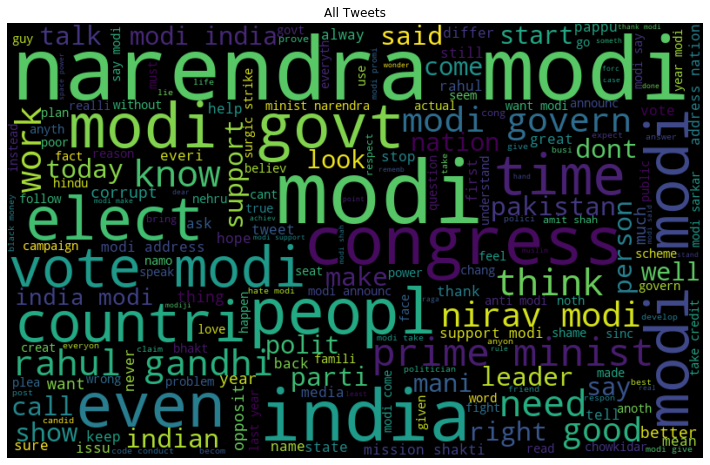

In [19]:
# visualize frequent words in all the tweets
all_words = " ".join([sentence for sentence in data['clean_text']])
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("All Tweets")
plt.show()


#### Observation - Narendra Modi, modi govt, congress, nirav modi, india, pakistan, etc are some of the words that come out as most frequent words in tweets from all sentiment categories. So we can assume that most of the tweets are Indian politics related.

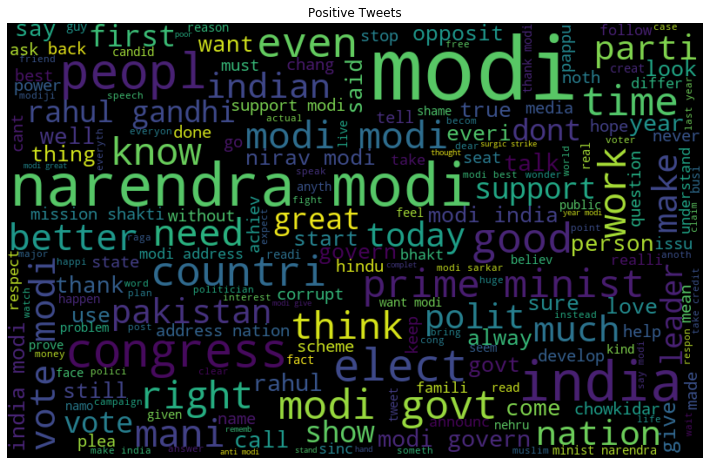

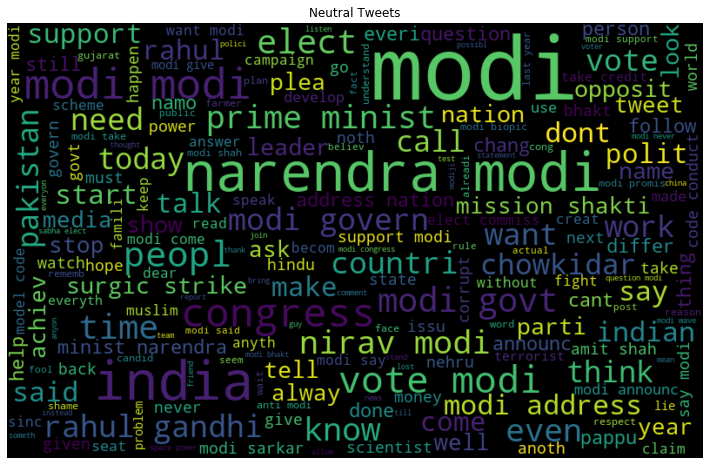

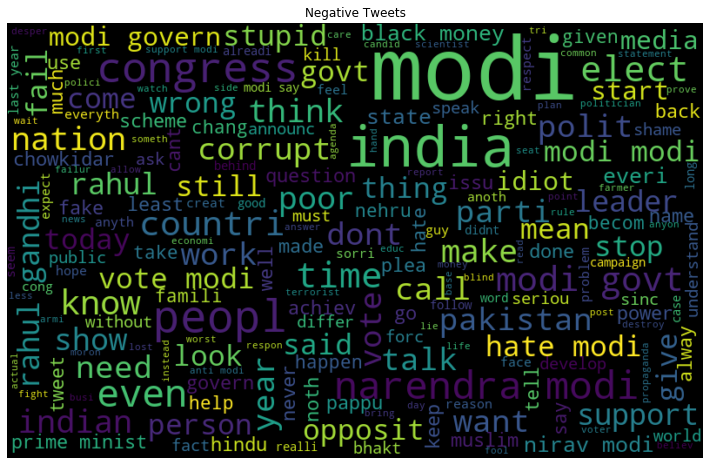

In [20]:
# visualize frequent words by sentiment category
for i in ['Positive', 'Neutral', 'Negative']:    
    all_words = " ".join([sentence for sentence in data['clean_text'][data['sentiment']==i]])
    wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(all_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("%s Tweets" %i)
    plt.show()

### Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data,data['category'],random_state=42, test_size=0.25)
X_train.drop(['category','sentiment','tweet_length'], axis=1, inplace=True)
X_test.drop(['category','sentiment','tweet_length'], axis=1, inplace=True)              

### Vactorizing Text data using BOW and TFIDF

In [24]:
# Bag of Words
bow_vectorizer=CountVectorizer( ngram_range=(1, 2),min_df=10, max_features=5000)
bow_train=bow_vectorizer.fit_transform(X_train['clean_text'])
bow_test=bow_vectorizer.fit_transform(X_test['clean_text'])

In [32]:
# TFIDF
tfidf_vectorizer=TfidfVectorizer(max_features = 5000,ngram_range = (1,2), min_df = 10)
tfidf_train=tfidf_vectorizer.fit_transform(X_train['clean_text'])
tfidf_test=tfidf_vectorizer.fit_transform(X_test['clean_text'])

### Model Training

In [33]:
# Logistic regressionn using One Vs rest
model=LogisticRegression(multi_class='ovr')
model.fit(tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
#Calculating the F1 score and accuracy
pred=model.predict(tfidf_test)
f1_score(y_test, pred, average='weighted')

0.3840335066268879

In [35]:
accuracy_score(y_test,pred)

0.40783919104653443

In [36]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier().fit(tfidf_train, y_train)
dtree_predictions = dtree_model.predict(tfidf_test)

In [37]:
print(f1_score(y_test, dtree_predictions, average='weighted'))
print(accuracy_score(y_test,dtree_predictions))

0.39166914364317074
0.3993471431376399


### Observations - We can see that the preliminary ML techniques like BOW and TFIDF are not able to classify the tweets with good accuracy. We would be better off applying Deep learning techniques like Nueral networks to get a better accuracy. Using better vectorization techniques like W2V (CBOW or skip gram) which help retain the context of the word will also help increase the accuracy of the model. We also need to do hyper parameter tuning of the existing models for better results. In this project our major focus was on EDA and data visualization.